## Problem 1


1a. Implementing and Populate a Bloom Filter (8 points)

In [2]:
from bitarray import bitarray
from hashlib import sha3_256, sha256, blake2b

# Create a Bloom Filter: Implement the filter using the bitarray library and a fixed number of bits to store word data.
class BloomFilter:
    def __init__(self, size, hashnum):
        self.size = size
        self.hashnum = hashnum
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)
    
    #apply all three hash functions
    def my_hash1(self, s):
        return int(sha256(s.lower().encode()).hexdigest(), 16) % self.size

    def my_hash2(self, s):
        return int(blake2b(s.lower().encode()).hexdigest(), 16) % self.size

    def my_hash3(self, s):
        return int(sha3_256(s.lower().encode()).hexdigest(), 16) % self.size

    def add(self, word):
        if self.hashnum == 1:
            indices = [self.my_hash1(word)]
        if self.hashnum == 2:
            indices = [self.my_hash1(word), self.my_hash2(word)]
        if self.hashnum == 3:    
            indices = [self.my_hash1(word), self.my_hash2(word), self.my_hash3(word)]
        for idx in indices:
            self.bit_array[idx] = 1

    def check(self, word):
        # Check if all the corresponding bits are set
        if self.hashnum == 1:
            indices = [self.my_hash1(word)]
        if self.hashnum == 2:
            indices = [self.my_hash1(word), self.my_hash2(word)]
        if self.hashnum == 3:    
            indices = [self.my_hash1(word), self.my_hash2(word), self.my_hash3(word)]
        return all(self.bit_array[idx] == 1 for idx in indices)
    
#Insert Words into the Bloom Filter
bloom_filter = BloomFilter(10**7,1)
with open('words.txt') as f:
    for line in f:
        word = line.strip()
        bloom_filter.add(word)
        

1b. Spell Check and Correction (10 points)

In [3]:
import string
import json
#Implement a Spelling Correction Function
def spell_check(word, bloom_filter):
    alphabet = string.ascii_lowercase
    suggestions = []

    #  checks all possible single-character substitutions for a given word using the Bloom filter
    for i in range(len(word)):
        for letter in alphabet:
            substitution = word[:i] + letter + word[i+1:]
            if bloom_filter.check(substitution):
                suggestions.append(substitution)

            #limit to 3 suggestion
            if len(suggestions) == 3:
                return suggestions
    return suggestions
            


#Implement a function to test how well the Bloom filter suggests corrections
def evaluate_performance(typo_file, bloom_filter):
    with open(typo_file) as f:
        typo_data = json.load(f)

    correct_suggestions = 0
    fp = 0
    total_tests = 0

    for typed_word, correct_word in typo_data:
        if typed_word != correct_word:
            suggestions = spell_check(typed_word, bloom_filter)
            if correct_word in suggestions: #good suggestion
                correct_suggestions += 1
            elif len(suggestions)>0:#fp
                fp += 1

            total_tests += 1

    return correct_suggestions / total_tests, fp/total_tests
performance,tp = evaluate_performance('typos.json',bloom_filter)
print(performance,tp)

0.28528 0.71472


In [4]:
import matplotlib.pyplot as plt

# Experiment with different Bloom filter sizes
sizes = [10**1,10**2,10**3,10**4,10**5,10**6,10**7, 10**8]
hash_func_combinations = [(1, '1hash'), (2, '2hash'), (3, '3hash')]
results = []

for size in sizes:
    for num_hash, label in hash_func_combinations:
        bloom_filter = BloomFilter(size,num_hash) #and combinations of 1, 2, or 3 hash functions
        with open('words.txt') as f:
            for line in f:
                word = line.strip()
                bloom_filter.add(word)
        performance,tp= evaluate_performance('typos.json', bloom_filter)
        results.append((size, num_hash, performance,tp))


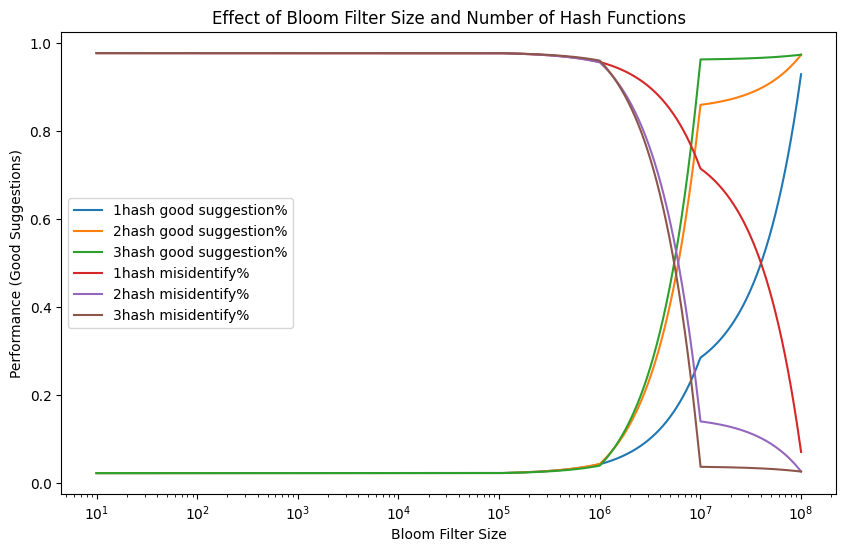

In [5]:
# Plot the results
from scipy.interpolate import interp1d
import numpy as np

#and good suggestions (as defined above)
plt.figure(figsize=(10, 6))
for num_hash, label in hash_func_combinations:
    x_data = np.array([r[0] for r in results if r[1] == num_hash])
    y_data = np.array([r[2] for r in results if r[1] == num_hash])
    interp_func = interp1d(x_data, y_data,kind='linear')
    x_smooth = np.logspace(np.log10(x_data.min()), np.log10(x_data.max()), 10000)
    y_smooth = interp_func(x_smooth)  
    plt.plot(x_smooth, y_smooth, label=label+' good suggestion%')

#Track the number of false positives
for num_hash, label in hash_func_combinations:
    x_data = np.array([r[0] for r in results if r[1] == num_hash])
    y_data = np.array([r[3] for r in results if r[1] == num_hash])
    interp_func = interp1d(x_data, y_data,kind='linear')
    x_smooth = np.logspace(np.log10(x_data.min()), np.log10(x_data.max()), 10000)
    y_smooth = interp_func(x_smooth)  
    plt.plot(x_smooth, y_smooth, label=label+' misidentify%')
#Plot the results
plt.xscale('log')
plt.xlabel('Bloom Filter Size')
plt.ylabel('Performance (Good Suggestions)')
plt.title('Effect of Bloom Filter Size and Number of Hash Functions')
plt.legend()
plt.show()

Approximately how many bits are necessary to achieve 85% good suggestions with each combination of 1, 2, or 3 hash functions?:  
for 1 hash: close to 10^8  
for 2,3 hash: close to 10^7

# Problem 2

In [2]:
#Adapt the alg2 merge sort to sort based on a key-value relationship.

def alg2_keyed(data):
    if len(data) <= 1:
        return data
    else:
        split = len(data) // 2
        #split the data to half
        left = iter(alg2_keyed(data[:split]))
        right = iter(alg2_keyed(data[split:]))
        result = []
        
        #first element of left and right, should be a tuple here
        left_top = next(left)
        right_top = next(right)
        
        while True:
            if left_top[0] < right_top[0]: #compare by key
                result.append(left_top)
                try:
                    left_top = next(left)
                except StopIteration:
                    return result + [right_top] + list(right)
            else:
                result.append(right_top)
                try:
                    right_top = next(right)
                except StopIteration:
                    return result + [left_top] + list(left)


In [7]:
# Provide examples demonstrating that your code works.

import random
data = [
    (3, 'C'),
    (1, 'A'),
    (2, 'B')
]
sorted_data = alg2_keyed(data)
print(sorted_data)

#how you know that it works 

def generate_random_data(num_pairs, key_range):
    return [(random.randint(*key_range), f'value_{i}') for i in range(num_pairs)]

def test_alg2_keyed():
    test_data = generate_random_data(1000,(1,1000))
    sorted_data = alg2_keyed(test_data)
    #test if all data is sorted
    keys_sorted = all(sorted_data[i][0] <= sorted_data[i+1][0] for i in range(len(sorted_data)-1))
    if keys_sorted:
        return True
    else:
        return False


flag = True
for i in range(1000):
    flag = test_alg2_keyed()
    if not flag:
        print('problem occurs')


print('the function is runing correctly ')
# for 1000 times the function is runing correctly 
# then I know

[(1, 'A'), (2, 'B'), (3, 'C')]
the function is runing correctly 


In [1]:
import multiprocessing as mp
# Want the extra 5 credis trying to get 1/3 of the sequencial time
# Implement a parallel version of your modified merge sort algorithm
# splitting the workload across multiple processing cores

def parallel_alg2_keyed(data, num_cores=16):
    if len(data) <= 1:
        return data
    #use the maximize cores that the pc supports
    if num_cores is None:
        num_cores = mp.cpu_count()
    
    print(num_cores)

    #if #cores larger then #data, no need to parrallel
    if num_cores > len(data):
        return alg2_keyed(data)

    # now we need num_cores data split
    split_size = len(data) // num_cores
    splits = [data[i * split_size:(i + 1) * split_size] for i in range(num_cores - 1)]
    splits.append(data[(num_cores - 1) * split_size:])
    
    # pool

    with mp.Pool(num_cores) as pool:
        sorted_splits = pool.map(alg2_keyed, splits)

            
    while len(sorted_splits) > 1:
        new_sorted_splits = []
        for i in range(0, len(sorted_splits), 2):
            if i + 1 < len(sorted_splits):
                new_sorted_splits.append(merge(sorted_splits[i], sorted_splits[i + 1]))
            else:
                new_sorted_splits.append(sorted_splits[i]) 
        sorted_splits = new_sorted_splits
        print(len(sorted_splits))

    return sorted_splits[0]

# for two splits, how to merge them into big splits
def merge(left, right):
    result = []
    i = j = 0
    while i < len(left) and j < len(right):
        if left[i][0] < right[j][0]:
            result.append(left[i])
            i += 1
        else:
            result.append(right[j])
            j += 1
    result.extend(left[i:])
    result.extend(right[j:])
    return result


In [ ]:
import time
# Measure and compare the performance of your parallel algorithm with the original serial version.
def measure_time(func, data):
    start_time = time.time()
    func(data)
    end_time = time.time()
    return end_time - start_time

dataset_sizes = [1000, 5000, 10000, 50000, 100000]
serial_times = []
parallel_times = []

for size in dataset_sizes:
    data = generate_random_data(size,(1,1000000))
    serial_times.append(measure_time(alg2_keyed, data))
    parallel_times.append(measure_time(parallel_alg2_keyed, data))

# Visualize the results: Use a log-log plot to compare the time complexity of the parallel and serial versions
# focusing on how the parallel implementation scales with larger datasets.
plt.figure(figsize=(8, 6))

#using loglog plot
plt.loglog(dataset_sizes, serial_times, label="Serial Merge Sort", marker='o')
plt.loglog(dataset_sizes, parallel_times, label="Parallel Merge Sort", marker='o')
plt.xlabel("Dataset Size")
plt.ylabel("Time (seconds)")
plt.legend()
plt.show()

### the ipynb doesnt support the parallel computing, which I seperate those part to another .py files and the outcome is at the end of the pdf files.   
we can see over the size of 10000000, the parallel time is already one third of the sequential time

We can see the time complexity for the serial versions is O(nlogn), for the parallel version the time complexity is still O(nlogn) but with a much smaller constant in the front which is O(n/p*log(n/p)). When the dataset is big, the time complexity still has a logarithmic component, but the n/p factor significantly reduces the workload for each processor, which significantly reduce the time. 

# Problem 3

In [2]:
import requests
import xml.etree.ElementTree as ET
import json
import time   

In [3]:
#Use the Entrez API to retrieve the PubMed IDs

def fetch_pubmed_ids(query, max_results=1000):
    base_url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term={query}&retmax=1000&retmode=xml"
    response = requests.get(base_url)
    time.sleep(1)  # Respect API rate limits
    root = ET.fromstring(response.content)
    ids = [id_elem.text for id_elem in root.findall(".//Id")]
    return ids

# Use a query structured like "Alzheimers+AND+2023[pdat]" for Alzheimer’s
# and "cancer+AND+2023[pdat]" for cancer.
alzheimers_ids = fetch_pubmed_ids("Alzheimers+AND+2023[pdat]")
cancer_ids = fetch_pubmed_ids("cancer+AND+2023[pdat]")

print(f"Fetched {len(alzheimers_ids)} Alzheimer's paper IDs.")
print(f"Fetched {len(cancer_ids)} cancer paper IDs.")

Fetched 1000 Alzheimer's paper IDs.
Fetched 1000 cancer paper IDs.


In [4]:
def fetch_metadata(pubmed_ids,type):
    base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"
    params = {
        "db": "pubmed",
        "id": ",".join(pubmed_ids),  # use a comma-separated list of IDs to retrieve metadata in batches
        "retmode": "xml"
    }
    
    response = requests.post(base_url, data=params)
    time.sleep(1)  
    root = ET.fromstring(response.content)

    metadata = {}
    for article in root.findall(".//PubmedArticle"):
        pmid = article.find(".//PMID").text
        title = article.find(".//ArticleTitle").text or ""
        abstract_elem = article.find(".//Abstract")
        
        if abstract_elem is not None:
            #has italics in their title or abstract
            # multiple sections in their abstract (problem 3.d)
            abstract_parts = [ET.tostring(item, method="text", encoding="unicode") for item in abstract_elem.findall(".//AbstractText")]
            abstract = " ".join(abstract_parts)
        else:
            abstract = "No abstract available"
        
        # Store metadata
        metadata[pmid] = {
            "ArticleTitle": title,
            "AbstractText": abstract,
            "query": type
        }
    
    return metadata

alzheimers_metadata = fetch_metadata(alzheimers_ids,"Alzheimer")
cancer_metadata = fetch_metadata(cancer_ids,"Cancer")

# Save the results in a JSON file structured 
with open('alzheimers_metadata.json', 'w') as f:
    json.dump(alzheimers_metadata, f, indent=4)

with open('cancer_metadata.json', 'w') as f:
    json.dump(cancer_metadata, f, indent=4)


In [6]:
#  Identify if there are any PubMed IDs that are present in both the Alzheimer’s and cancer paper sets.
print(set(alzheimers_ids).intersection(set(cancer_ids)))


{'38948505', '38694619', '39280063'}


The correction has already added to the previous code.   
Limitation: For 3.d, the abstract is concatenated into a single string, separated by spaces, which can leads to a loss of the structure, making it difficult to identify the different sections in the abstract once merged.

# Problem 4

In [3]:
from transformers import AutoTokenizer, AutoModel

# Setup
tokenizer = AutoTokenizer.from_pretrained('allenai/specter')
model = AutoModel.from_pretrained('allenai/specter')

c:\Users\jackchang\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [7]:
#Load the papers dictionary (3 points)
import tqdm

# we can use a persistent dictionary (via shelve) so we can stop and restart if needed
# alternatively, do the same but with embeddings starting as an empty dictionary
papers = {**alzheimers_metadata,**cancer_metadata}
embeddings = {}
for pmid, paper in tqdm.tqdm(papers.items()):
    data = [paper["ArticleTitle"] + tokenizer.sep_token + paper["AbstractText"]]
    inputs = tokenizer(
        data, padding=True, truncation=True, return_tensors="pt", max_length=512
    )
    result = model(**inputs)
    # take the first token in the batch as the embedding
    embeddings[pmid] = result.last_hidden_state[:, 0, :].detach().numpy()[0]

#process your dictionary of papers to find the SPECTER embeddings(2 points)
# turn our dictionary into a list
embeddings = [embeddings[pmid] for pmid in papers.keys()]

100%|██████████| 1997/1997 [10:01<00:00,  3.32it/s]


In [8]:
#Apply principal component analysis (PCA) to identify the first three principal components. 
from sklearn import decomposition
import pandas as pd
pca = decomposition.PCA(n_components=3)
embeddings_pca = pd.DataFrame(
    pca.fit_transform(embeddings),
    columns=['PC0', 'PC1', 'PC2']
)
embeddings_pca["query"] = [paper["query"] for paper in papers.values()]

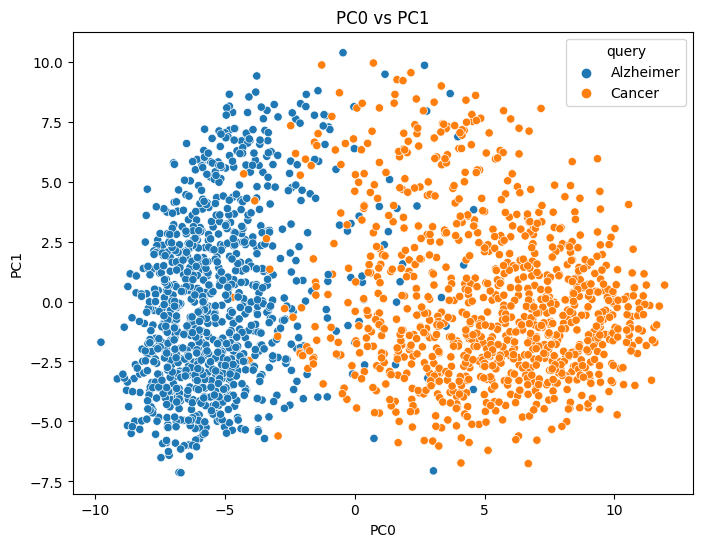

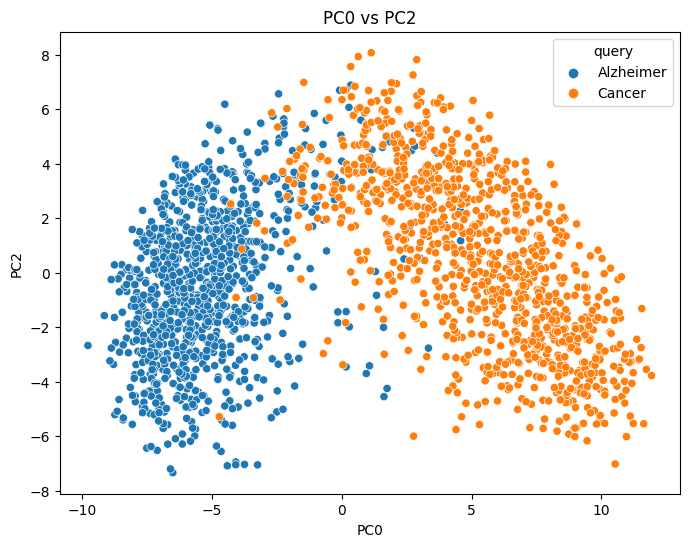

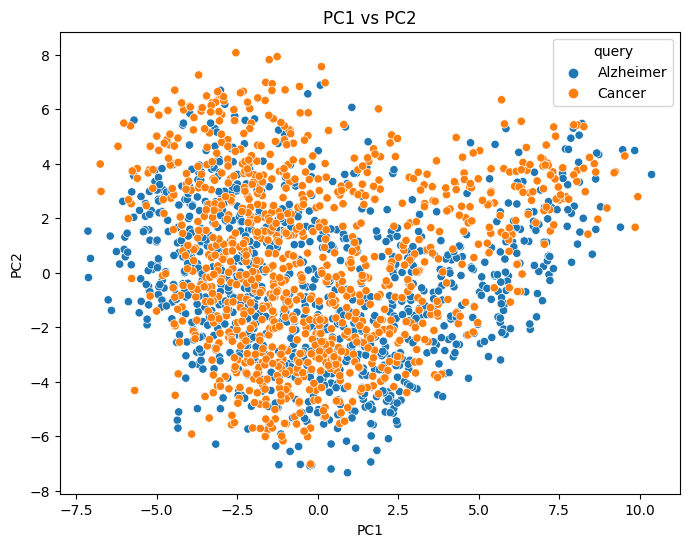

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

#Plot 2D scatter plots for PC0 vs PC1, PC0 vs PC2, and PC1 vs PC2; color code these by the search query used (Alzheimers vs cancer).
# Plot PC0 vs PC1
plt.figure(figsize=(8,6))
sns.scatterplot(x='PC0', y='PC1', hue='query', data=embeddings_pca)
plt.title('PC0 vs PC1')
plt.show()

# Plot PC0 vs PC2
plt.figure(figsize=(8,6))
sns.scatterplot(x='PC0', y='PC2', hue='query', data=embeddings_pca)
plt.title('PC0 vs PC2')
plt.show()

# Plot PC1 vs PC2
plt.figure(figsize=(8,6))
sns.scatterplot(x='PC1', y='PC2', hue='query', data=embeddings_pca)
plt.title('PC1 vs PC2')
plt.show()

### Analysis  
For PC0 vs PC1 and PC0 vs PC2, the seperation is good, the SPECTER embeddings capture substantial differences between the two categories in their abstracts and titles. For PC1 vs PC2, there exist a large overlap in two catagory, which suggests a bad seperate, PC1 and PC2 alone do not differentiate Alzheimer's and cancer papers as effectively.  
The takeaways are PC0 is the best discriminator among three component as it shows clear seperation vs all other components. When we use PC1 and PC2 together we might not have a good result as the seperation is not clear and mixed together. Also SPECTER embeddings effectively capture meaningful distinctions in those artical text content.